In [1]:
# %matplotlib inline
# %matplotlib widget
# %matplotlib notebook

import warnings
warnings.filterwarnings(action='ignore')

import sys
sys.path.append('../configs/')
sys.path.append('../helper/')
sys.path.append('../models/')
sys.path.append('../data_processing/')

import torch
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as mticker
import glob
import random
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec
import importlib
from ml_collections import config_flags
from absl import app
from absl import flags
from sklearn.metrics import explained_variance_score
from scipy.stats import skew
from scipy.stats import kurtosis
from tqdm import tqdm

import models
import helper_functions as hpfn
import configs_data_natural as confdn
import configs_model_natural as confmn
import configs_model_natural_inverted as confmni
import configs_model_natural_phase_randomized as confmnpr
import configs_model_gaussian as confmg
import moving_edges
import sawtooth_gradient


In [2]:
importlib.reload(confmn)

# get lists of hyper parameters
configdn = confdn.get_config()
configmn = confmn.get_config()
Repeat = configmn.Repeat # repeat for different initializations
activationf = configmn.activationf # activation functions, which can be 'ReLU', 'LeakyReLU' or 'ELU'.
T = configmn.T # length in time (one for 10 ms)
od = configmn.od

figure_folder_paper = '../results/figures_for_paper/'
if not os.path.exists(figure_folder_paper):
    os.makedirs(figure_folder_paper)
    
variable_folder_paper = '../results/variables_for_paper/'
if not os.path.exists(variable_folder_paper):
    os.makedirs(variable_folder_paper)
    
data_type_list = ['original', 'inverted', 'phase_randomized', 'gaussian']
color_list4_old = [[27/255, 158/255, 119/255], [217/255, 95/255, 2/255], [117/255, 112/255, 179/255], [231/255, 41/255, 138/255]]
color_list4 = [[240/255, 2/255, 127/255], [102/255, 102/255, 102/255], [190/255, 174/255, 212/255], [253/255, 192/255, 134/255]]

#### Panel 1, illustration of the natural scene data

The shape of the image is (251, 927).
Degrees per pixel in the horizontal dimension is 0.3883495145631068.
Degrees per pixel in the vertical dimension is 0.3884462151394422.


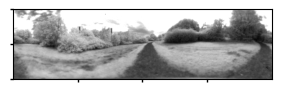

In [3]:
data_folder = '/mnt/d/data/'
folder_nat = data_folder + 'panoramic/data_natural_only/'
folder_nat_filtered = data_folder + 'panoramic/data_natural_only_filtered/'

# Show an example of the image
# 97.5 deg vertically, 360 deg horizontally
ii = 3
nat_numbers = np.load(data_folder + 'panoramic/natural_scenes_numbers.npy')
img = np.load(folder_nat + f'natural_{nat_numbers[ii]}.npy')
K_row = img.shape[0] 
K_col = img.shape[1] 
print(f'The shape of the image is {img.shape}.')
print(f'Degrees per pixel in the horizontal dimension is {360/img.shape[1]}.')
print(f'Degrees per pixel in the vertical dimension is {97.5/img.shape[0]}.')

# filter, resize and calculate the contrast
K_row = img.shape[0] 
K_col = img.shape[1] 
pix_per_deg = K_col / 360
FWHM = 5 # in degree
sigma_for_gaussian = np.round(FWHM/(2*np.sqrt(2*np.log(2)))*pix_per_deg, 1) # smoothing gaussian
pad_size = int(4*sigma_for_gaussian) # this comes from the fact that the gaussian is truncated at 4*std
img_filtered = hpfn.get_filtered_spacial(img, pad_size, sigma_for_gaussian)
img_resized = hpfn.get_resized(img_filtered)
img_contrast = hpfn.get_contrast(img_resized.reshape((1,)+img_resized.shape), '30deg')

font_size = 10
label_size = 10

fig = plt.figure(figsize=(3, 3*K_row/K_col), constrained_layout=True)
gs = GridSpec(1, 1, figure=fig)

ax = fig.add_subplot(gs[0, 0])
im = ax.imshow(img, 'gray')
ax.set_xticks([K_col/4, K_col/4*2, K_col/4*3])
ax.set_yticks([0, 125, 250])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(direction='out', length=2, width=1, labelsize=label_size)
# ax.set_xlabel(r'Azimuth ($\degree$)', fontsize=font_size)
# ax.set_ylabel(r'Elevation ($\degree$)', fontsize=font_size)

plt.savefig(figure_folder_paper + f'natural_scene_{nat_numbers[ii]}.pdf', bbox_inches='tight')
plt.show()


#### Sample velocity trajectory

The standard deviation of the velocity is 98.6842496797381


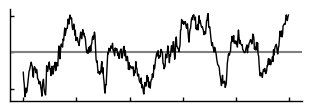

In [9]:
# Generate a list of velocities and look at the autocorrelation function
gamma1 = np.log(2.)/0.2 # half-life is 0.2 second
delta_t = 0.01 # simulation step is 0.01 second
acc_length = 1000 # length of the acceleration array
vel_length = 500 # length of the velocity trace
scal = 100 # one standard deviation for the velocity, in degree/s
acc_mean = 0 # mean of the acceleration, in degree/s^2
acc_std = scal * np.sqrt(2 * gamma1 / (1 - np.exp(-2 * gamma1 * acc_length * delta_t)) / delta_t) # standard deviation of the acceleration, in degree/s^2
N = 1000 # number of velocity traces

vel_list = []
vel_autoc_list = []
for n in range(N):
    acc_array = np.random.normal(acc_mean, acc_std, acc_length)
    vel_array = hpfn.get_filtered_OU_1d(gamma1, delta_t, acc_array, vel_length)
    vel_list.append(vel_array)
    vel_autoc = np.correlate(vel_array, vel_array, 'same') # calculate autocorrelation
    vel_autoc_list.append(vel_autoc)
vel_autoc_array = np.array(vel_autoc_list)
vel_autoc_mean = vel_autoc_array.mean(axis=0) / scal**2

print(f'The standard deviation of the velocity is {np.array(vel_list).std(axis=0).mean()}')

line_width = 1
font_size = 10
label_size = 10

fig = plt.figure(figsize=(3, 1), constrained_layout=True)
gs = GridSpec(1, 1, figure=fig)

ax = fig.add_subplot(gs[0, 0])
ax.axhline(0, color='gray')
ax.plot(np.arange(vel_length)*delta_t, vel_array, 'k', linewidth=line_width)
ax.set_xticks([0, 1, 2, 3, 4, 5], [])
ax.set_yticks([-200, 0, 200], [])
# ax.set_xlabel('Time (s)', fontsize=font_size)
# ax.set_ylabel(r'Velocity ($\degree$/s)', fontsize=font_size)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)
ax.spines["bottom"].set_linewidth(1)
ax.spines["left"].set_linewidth(1)
ax.tick_params(direction='in', length=3, width=1, labelsize=label_size)

plt.savefig(figure_folder_paper + f'sample_velocity_trace.pdf', bbox_inches='tight')
plt.show()

#### Panel 2, illustrations of training data

In [4]:
gamma1 = configdn.gamma1 # half-life is 0.2 second
delta_t = configdn.delta_t # simulation step is 0.01 second
acc_length = configdn.acc_length # length of the acceleration array
vel_length = configdn.vel_length # length of the velocity array
scal = configdn.velocity_scale # one standard deviation for the velocity, in degree/s
acc_mean = configdn.acc_mean # mean of the acceleration, in degree/s^2
acc_std = configdn.acc_std # standard deviation of the acceleration, in degree/s^2

acc_array = np.random.normal(acc_mean, acc_std, acc_length)
vel_array = hpfn.get_filtered_OU_1d(gamma1, delta_t, acc_array, vel_length)

# Normal order
_, shift_array_pix = hpfn.get_shift_array(vel_array, delta_t, img)
img_processed = []
for shift in shift_array_pix:
    img_roll = np.roll(img_filtered, shift, axis=1)
    img_resized = hpfn.get_resized(img_roll)
    img_processed.append(img_resized)
img_processed = np.array(img_processed)
img_contrast = hpfn.get_contrast(img_processed, '30deg')
print(img_contrast.shape)
       
# # Reversed order to enforce symmetry
# _, shift_array_pix = hpfn.get_shift_array(vel_array, delta_t, img)
# img_processed_reversed = []
# for shift in shift_array_pix:
#     img_roll = np.roll(np.flip(img_filtered, axis=1), -shift, axis=1)
#     img_resized = hpfn.get_resized(img_roll)
#     img_processed_reversed.append(img_resized)
# img_processed_reversed = np.array(img_processed_reversed)
# img_contrast_reversed = hpfn.get_contrast(img_processed_reversed, '30deg')
# print(img_contrast_reversed.shape)        

(50, 20, 72)


In [5]:
K_col/K_row

3.693227091633466

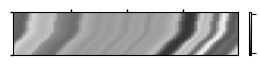

In [7]:
font_size = 10
label_size = 10

fig = plt.figure(figsize=(2.5, 2.5*K_row/K_col), constrained_layout=True)
gs = GridSpec(1, 1, figure=fig)

axes_list = []
ax = fig.add_subplot(gs[0, 0])
axes_list.append(ax)
im = ax.imshow(img_contrast[:50, 4, :], 'gray', vmin=-0.55, vmax=0.55)
ax.invert_yaxis()
ax.set_yticks([0, 50], [])
ax.set_xticks([18, 36, 54], [])
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False, direction='out', length=2, width=1, labelsize=label_size)
ax.set_aspect(K_row/K_col)


cbar = plt.colorbar(im, ax=axes_list, location='right', orientation='vertical', fraction=.0095, ticks=[-0.5, 0.5], format=mticker.FixedFormatter([]))
cbar.ax.tick_params(labelsize=label_size)

plt.savefig(figure_folder_paper + f'natural_scene_{nat_numbers[ii]}_training_sample.pdf', bbox_inches='tight')
plt.show()

#### Panel 3, illustration of the model, done in illustrator directly

#### Panel 4, training, validating and testing results, the simplest model C = 2, D = 1, to be in supp

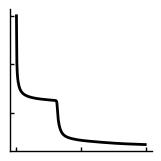

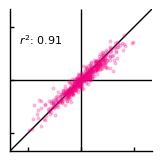

In [3]:
# loss function
D_cnn = 1
C = 2
R = 0
model_folder = f'../results/trained_models_natural_original/'
model_path = model_folder + f'Dcnn{D_cnn}_C{C}_' + configmn.activationf + f'_R{R+1}/'

font_size = 10
label_size = 10
line_width = 2

fig = plt.figure(figsize=(1.5, 1.5), constrained_layout=True)
gs = GridSpec(1, 1, figure=fig)

ax = fig.add_subplot(gs[0, 0])
if os.path.exists(model_path + f'train_loss.pth'):
    # train loss
    loss_path = model_path + f'train_loss.pth'
    loss = torch.load(loss_path)
    lines = ax.plot(loss, c='k', linewidth=line_width)
# ax.set_xlabel('Epoch', fontsize=font_size)
# ax.set_ylabel(r'Loss (($\degree/s)^{2}$)', fontsize=font_size)
ax.set_xticks([0, 150, 300], [])
ax.set_yticks([2500, 5000, 7500], [])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)
ax.spines["bottom"].set_linewidth(1)
ax.spines["left"].set_linewidth(1)
ax.tick_params(direction='in', length=3, width=1, labelsize=label_size)

fig.savefig(figure_folder_paper + f'loss_models_Dcnn{D_cnn}C{C}.pdf', bbox_inches='tight')


font_size = 9
label_size = 9
line_width = 2

# predicted velocity
y_test_all = torch.load(model_path + f'y_test_all.pth')
y_pred_all = torch.load(model_path + f'y_pred_all.pth')
explained_variance = np.round(explained_variance_score(y_test_all, y_pred_all), 2)
direction_accuracy = np.round((np.sign(y_test_all) == np.sign(y_pred_all)[:, 0]).sum()/len(y_pred_all), 2)

fig = plt.figure(figsize=(1.5, 1.5), constrained_layout=True)
gs = GridSpec(1, 1, figure=fig)

ax = fig.add_subplot(gs[0, 0])
ax.vlines(0, -400, 400, 'k', linewidth=1)
ax.hlines(0, -400, 400, 'k', linewidth=1)
ax.plot([-400, 400], [-400, 400], 'k', linewidth=1)
ax.plot(y_test_all[::100], y_pred_all[::100], '.', c=color_list4[0], markersize=4, alpha=0.2)
ax.axis('scaled')
# ax.set_xlabel(r'Targets ($\degree$/s)', fontsize=font_size)
# ax.set_ylabel(r'Predicted ($\degree$/s)', fontsize=font_size)
ax.set_xlim([-400, 400])
ax.set_ylim([-400, 400])
ax.set_xticks([-300, 0, 300], [])
ax.set_yticks([-300, 0, 300], [])
ax.text(-350, 200, f'$r^{2}$: {explained_variance}', fontsize=8)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)
ax.spines["bottom"].set_linewidth(1)
ax.spines["left"].set_linewidth(1)
ax.tick_params(direction='in', length=3, width=1, labelsize=label_size)

fig.savefig(figure_folder_paper + f'predicted_velocity_models_Dcnn{D_cnn}C{C}.pdf', bbox_inches='tight')
plt.show()    
    

#### Panel 5,  sythetic testing stimuli

In [4]:
# moving edges
def illustrate_one_white_moving_edge(vv, p, rescalev=0.1):
    K_row = 1
    K_col = 720
    delta_t = 0.002 # simulation step is 0.01 second
    
    T = int((360/p)/vv*500)
    synthetic_data_white_edge = np.zeros((1, T, 1, 720))
    vel = np.ones(T-1) * vv
    
    img = -rescalev * np.ones((K_row, K_col))
    for ii in range(p):
        img[:, ii*int(720/p)] = rescalev
    _, shift_array_pix = hpfn.get_shift_array(vel, delta_t, img)
    for tt, shift in enumerate(shift_array_pix):
        for ii in range(p):
            img[:, ii*int(720/p):ii*int(720/p)+shift] = rescalev
        synthetic_data_white_edge[0, tt, :, :] = img[:, :]
            
    synthetic_data_black_edge = -synthetic_data_white_edge
    
    return synthetic_data_white_edge, synthetic_data_black_edge


# static sawtooth
def illustrate_one_static_sawtooth(xtess, rescalev):
    importlib.reload(sawtooth_gradient)

    stim_bundler = np.zeros((1, 500, 1, 720))
    stimr = sawtooth_gradient.get_bitmap(direction = 'r', xtess = xtess, x = 720, t = 500)
    stim_bundler[0, :, 0, :] = stimr[:, :] * rescalev

    stim_bundlel = np.zeros((1, 500, 1, 720))
    stiml = sawtooth_gradient.get_bitmap(direction = 'l', xtess = xtess, x = 720, t = 500)
    stim_bundlel[0, :, 0, :] = stiml[:, :] * rescalev
    
    return stim_bundler, stim_bundler


# s14
s_14 = [1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, -1, -1, -1, 1, 1]
s_14_shape = [4, 2]

def illustrate_S14(resc, s_14, s_14_shape, timeR=False, contrastR=False):

    S_raw = moving_edges.get_bitmap(s_14, s_14_shape, xtess = 12, ttess = 1, t = 500) / 2 * resc
    if timeR:
        S_raw = S_raw[::-1, :]
    if contrastR:
        S_raw = -S_raw
        
    S14 = np.zeros((1, 500, 1, 720))
    S14[0, :, 0, :] = S_raw
                
    return S14

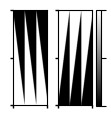

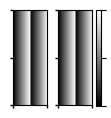

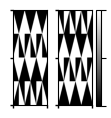

In [5]:

rescalev = 0.05

# moving edges
synthetic_data_white_edge, _ = illustrate_one_white_moving_edge(vv=30, p=12, rescalev=0.05)

# static sawtooth
stim_bundler, _ = illustrate_one_static_sawtooth(xtess=8, rescalev=0.05)

# s14
S14 = illustrate_S14(rescalev, s_14, s_14_shape, timeR=False, contrastR=False)

    
font_size = 8
label_size = 8

# moving edges
fig = plt.figure(figsize=(1, 1.5), constrained_layout=True)
gs = GridSpec(1, 2, figure=fig)

axes_list = []
ax = fig.add_subplot(gs[0, 0])
axes_list.append(ax)
im = ax.imshow(synthetic_data_white_edge[0].squeeze()[:, :180], 'gray', vmin=-0.05, vmax=0.05)
ax.set_yticks([0, 250, 500])
ax.set_yticklabels([])
ax.set_xticks([0, 180])
ax.set_xticklabels([])
# ax.set_ylabel(r'Azimuth ($\degree$)', fontsize=font_size)
ax.tick_params(direction='out', length=2, width=1, labelsize=label_size)

ax = fig.add_subplot(gs[0, 1])
axes_list.append(ax)
im = ax.imshow(synthetic_data_white_edge[0].squeeze()[::-1][:, :180], 'gray', vmin=-0.05, vmax=0.05)
ax.set_yticks([0, 250, 500])
ax.set_yticklabels([])
ax.set_xticks([0, 180])
ax.set_xticklabels([])
# ax.set_xlabel('Time (s)', fontsize=font_size)
ax.tick_params(direction='out', length=2, width=1, labelsize=label_size)

cbar = plt.colorbar(im, ax=axes_list, orientation='vertical', fraction=.06, ticks=[-0.05, 0, 0.05], format=mticker.FixedFormatter([]))
cbar.ax.tick_params(labelsize=label_size)

plt.savefig(figure_folder_paper + f'synthetic_test_stimuli_moving_edge.pdf', bbox_inches='tight')
plt.show()


# static sawtooth
fig = plt.figure(figsize=(1, 1.5), constrained_layout=True)
gs = GridSpec(1, 2, figure=fig)

axes_list = []
ax = fig.add_subplot(gs[0, 0])
axes_list.append(ax)
im = ax.imshow(stim_bundler[0].squeeze()[:, :180], 'gray', vmin=-0.05, vmax=0.05)
ax.set_yticks([0, 250, 500])
ax.set_yticklabels([])
ax.set_xticks([0, 180])
ax.set_xticklabels([])
# ax.set_ylabel(r'Azimuth ($\degree$)', fontsize=font_size)
ax.tick_params(direction='out', length=2, width=1, labelsize=label_size)

ax = fig.add_subplot(gs[0, 1])
axes_list.append(ax)
im = ax.imshow(stim_bundler[0].squeeze()[::-1][:, :180], 'gray', vmin=-0.05, vmax=0.05)
ax.set_yticks([0, 250, 500])
ax.set_yticklabels([])
ax.set_xticks([0, 180])
ax.set_xticklabels([])
# ax.set_xlabel('Time (s)', fontsize=font_size)
ax.tick_params(direction='out', length=2, width=1, labelsize=label_size)

cbar = plt.colorbar(im, ax=axes_list, orientation='vertical', fraction=.06, ticks=[-0.05, 0, 0.05], format=mticker.FixedFormatter([]))
cbar.ax.tick_params(labelsize=label_size)

plt.savefig(figure_folder_paper + f'synthetic_test_stimuli_sawtooth.pdf', bbox_inches='tight')
plt.show()


# s14
fig = plt.figure(figsize=(1, 1.5), constrained_layout=True)
gs = GridSpec(1, 2, figure=fig)

axes_list = []
ax = fig.add_subplot(gs[0, 0])
axes_list.append(ax)
im = ax.imshow(S14[0].squeeze()[:, :180], 'gray', vmin=-0.05, vmax=0.05)
ax.set_yticks([0, 250, 500])
ax.set_yticklabels([])
ax.set_xticks([0, 180])
ax.set_xticklabels([])
# ax.set_ylabel(r'Azimuth ($\degree$)', fontsize=font_size)
ax.tick_params(direction='out', length=2, width=1, labelsize=label_size)

ax = fig.add_subplot(gs[0, 1])
axes_list.append(ax)
im = ax.imshow(S14[0].squeeze()[::-1][:, :180], 'gray', vmin=-0.05, vmax=0.05)
ax.set_yticks([0, 250, 500])
ax.set_yticklabels([])
ax.set_xticks([0, 180])
ax.set_xticklabels([])
# ax.set_xlabel('Time (s)', fontsize=font_size)
ax.tick_params(direction='out', length=2, width=1, labelsize=label_size)

cbar = plt.colorbar(im, ax=axes_list, orientation='vertical', fraction=.06, ticks=[-0.05, 0, 0.05], format=mticker.FixedFormatter([]))
cbar.ax.tick_params(labelsize=label_size)

plt.savefig(figure_folder_paper + f'synthetic_test_stimuli_s14.pdf', bbox_inches='tight')
plt.show()


#### Panel 6, model response to the sythetic testing stimuli

In [5]:
moving_edges_results_all = np.load('../results/variables_for_paper/moving_edges_results_all.npy')
sawtooth_results_all = np.load('../results/variables_for_paper/sawtooth_results_all.npy')
stimulus_1420_results_all = np.load(f'../results/variables_for_paper/stimulus_1420_results_all_xtess12.npy')
print(moving_edges_results_all.shape)
print(sawtooth_results_all.shape)
print(stimulus_1420_results_all.shape)

R_performance_array = np.load(f'../results/variables_for_paper/R_performance_array_natural_C{2}_D{1}_thres{0.8}.npy')
print(R_performance_array.shape)
R_performance_array = (R_performance_array[:, 0]-1).astype(int)
print(R_performance_array.shape)

(4, 2, 4, 5, 6, 500, 2)
(4, 2, 4, 7, 500, 2)
(4, 2, 4, 5, 500, 2)
(477, 3)
(477,)


In [6]:
ii = 0
indC = 0
indD = 0
indr = 1
indv = 5
moving_edges_results_C2D1 = moving_edges_results_all[ii, indC, indD, indr, indv, :, :][R_performance_array]
print(moving_edges_results_C2D1.shape)

indr = 0
sawtooth_results_C2D1 = sawtooth_results_all[ii, indC, indD, indr, :, :][R_performance_array]
print(sawtooth_results_C2D1.shape)

indr = 0
s14_results_C2D1 = stimulus_1420_results_all[ii, indC, indD, indr, :, 0][R_performance_array]
print(s14_results_C2D1.shape)

(477, 2)
(477, 2)
(477,)


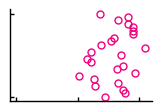

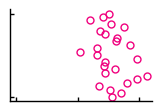

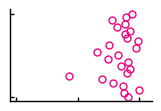

In [7]:
font_size = 9
label_size = 9
marker_size = 5

indconfig = 0
color_v = color_list4[0]

fig = plt.figure(figsize=(1.5, 1.), constrained_layout=True)
gs = GridSpec(1, 1, figure=fig)

ax = fig.add_subplot(gs[0, 0])
ax.plot(moving_edges_results_C2D1[:25, 0]-moving_edges_results_C2D1[:25, 1], range(len(moving_edges_results_C2D1[:25, 0])), 'o', markersize=marker_size, markeredgecolor=color_v, markerfacecolor='None')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)
ax.spines["bottom"].set_linewidth(1)
ax.spines["left"].set_linewidth(1)
ax.set_xlim(-0.4, 8.8)
ax.set_xticks([0, 4, 8], [])
ax.set_yticks([0, 24], [])
ax.tick_params(direction='in', length=3, width=1, labelsize=label_size)

fig.savefig(figure_folder_paper+'synthetic_stimuli_predicted_vel_moving_edge.pdf', bbox_inches='tight')


fig = plt.figure(figsize=(1.5, 1.), constrained_layout=True)
gs = GridSpec(1, 1, figure=fig)
ax = fig.add_subplot(gs[0, 0])
ax.plot(sawtooth_results_C2D1[:25, 0]*2, range(len(sawtooth_results_C2D1[:25, 0])), 'o', markersize=marker_size, markeredgecolor=color_v, markerfacecolor='None')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)
ax.spines["bottom"].set_linewidth(1)
ax.spines["left"].set_linewidth(1)
ax.set_xlim(-6, 132)
ax.set_xticks([0, 60, 120], [])
ax.set_yticks([0, 24], [])
ax.tick_params(direction='in', length=3, width=1, labelsize=label_size)

fig.savefig(figure_folder_paper+'synthetic_stimuli_predicted_vel_sawtooth.pdf', bbox_inches='tight')


fig = plt.figure(figsize=(1.5, 1.), constrained_layout=True)
gs = GridSpec(1, 1, figure=fig)
ax = fig.add_subplot(gs[0, 0])
ax.plot(s14_results_C2D1[:25]*2, range(len(s14_results_C2D1[:25])), 'o', markersize=marker_size, markeredgecolor=color_v, markerfacecolor='None')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)
ax.spines["bottom"].set_linewidth(1)
ax.spines["left"].set_linewidth(1)
ax.set_xlim(-0.6, 13.2)
ax.set_xticks([0, 6, 12], [])
ax.set_yticks([0, 24], [])
ax.tick_params(direction='in', length=3, width=1, labelsize=label_size)

fig.savefig(figure_folder_paper+'synthetic_stimuli_predicted_vel_s14.pdf', bbox_inches='tight')

plt.show()


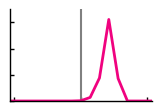

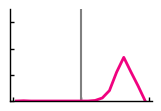

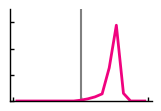

In [8]:
importlib.reload(hpfn)

font_size = 10
label_size = 10
color_v = color_list4[0]

fig = plt.figure(figsize=(1.5, 1.), constrained_layout=True)
gs = GridSpec(1, 1, figure=fig)

ax = fig.add_subplot(gs[0, 0])
ax.axvline(0, color='gray')
bins = np.linspace(-20, 20, 20)
diff_ = moving_edges_results_C2D1[:, 0] - moving_edges_results_C2D1[:, 1]
hist, bin_edges = np.histogram(diff_, bins)
bin_centers = 0.5*(bin_edges[:-1]+bin_edges[1:])
ax.plot(bin_centers, hist / len(R_performance_array), '-', c=color_v, linewidth=2)
ax.set_ylim([0, 0.7])
ax.set_xlim([-16, 16])
ax.set_yticks([0, 0.2, 0.4, 0.6], [])
ax.set_xticks([-15, 0, 15], [])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)
ax.spines["bottom"].set_linewidth(1)
ax.spines["left"].set_linewidth(1)
ax.tick_params(direction='in', length=3, width=1, labelsize=label_size)
# ax.set_ylabel('Fraction of \ntrained models\ntested on moving edges', fontsize=font_size)

fig.savefig(figure_folder_paper+'moving_edge_compare_C2D1.pdf', bbox_inches='tight')


fig = plt.figure(figsize=(1.5, 1.), constrained_layout=True)
gs = GridSpec(1, 1, figure=fig)

ax = fig.add_subplot(gs[0, 0])
ax.axvline(0, color='gray')
sawtooth_list = sawtooth_results_C2D1[:, 0] * 2
bins = np.linspace(-150, 150, 20)
hist, bin_edges = np.histogram(sawtooth_list, bins)
bin_centers = 0.5*(bin_edges[:-1]+bin_edges[1:])
ax.plot(bin_centers, hist / len(R_performance_array), '-', c=color_v, linewidth=2)
ax.set_ylim([0, 0.7])
ax.set_yticks([0, 0.2, 0.4, 0.6], [])
ax.set_xticks([-150, 0, 150], [])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)
ax.spines["bottom"].set_linewidth(1)
ax.spines["left"].set_linewidth(1)
ax.tick_params(direction='in', length=3, width=1, labelsize=label_size)
# ax.set_ylabel('Fraction of \ntrained models\ntested on sawtooth', fontsize=font_size)

fig.savefig(figure_folder_paper+'sawtooth_compare_C2D1.pdf', bbox_inches='tight')

fig = plt.figure(figsize=(1.5, 1.), constrained_layout=True)
gs = GridSpec(1, 1, figure=fig)

ax = fig.add_subplot(gs[0, 0])
ax.axvline(0, color='gray')
bins = np.linspace(-20, 20, 20)
s14_list = s14_results_C2D1 * 2
hist, bin_edges = np.histogram(s14_list, bins)
bin_centers = 0.5*(bin_edges[:-1]+bin_edges[1:])
ax.plot(bin_centers, hist / len(R_performance_array), '-', c=color_v, linewidth=2)
ax.set_ylim([0, 0.7])
ax.set_xlim([-21, 21])
ax.set_yticks([0, 0.2, 0.4, 0.6], [])
ax.set_xticks([-20, 0, 20], [])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)
ax.spines["bottom"].set_linewidth(1)
ax.spines["left"].set_linewidth(1)
ax.tick_params(direction='in', length=3, width=1, labelsize=label_size)

fig.savefig(figure_folder_paper+'s14_compare_C2D1.pdf', bbox_inches='tight')

plt.show()

In [9]:
ii = 0
indC = 0
indD = 0
indv = 5
moving_edges_results_C2D1_allr = moving_edges_results_all[ii, indC, indD, :, indv, R_performance_array, :]
print(moving_edges_results_C2D1_allr.shape)

sawtooth_results_C2D1_allr = sawtooth_results_all[ii, indC, indD, :, R_performance_array, :]
print(sawtooth_results_C2D1_allr.shape)

s14_results_C2D1_allr = stimulus_1420_results_all[ii, indC, indD, :, R_performance_array, 0]
print(s14_results_C2D1_allr.shape)

(477, 5, 2)
(477, 7, 2)
(477, 5)


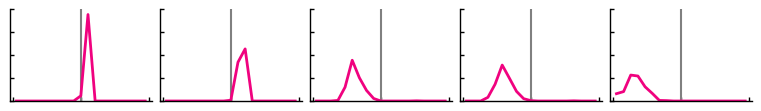

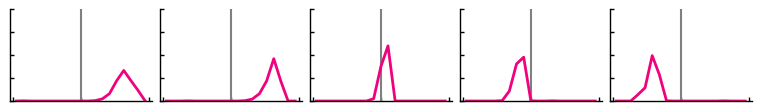

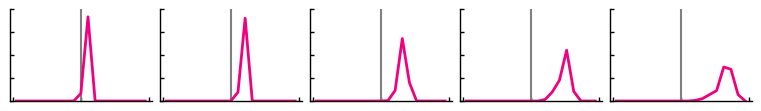

In [10]:
importlib.reload(hpfn)

font_size = 11
label_size = 11

fig = plt.figure(figsize=(1.5*5, 1.), constrained_layout=True)
gs = GridSpec(1, 5, figure=fig)
for indr in range(5):
    ax = fig.add_subplot(gs[0, indr])
    ax.axvline(0, color='gray')
    bins = np.linspace(-40, 40, 20)
    diff_ = moving_edges_results_C2D1_allr[:, indr, 0] - moving_edges_results_C2D1_allr[:, indr, 1]
    hist, bin_edges = np.histogram(diff_, bins)
    bin_centers = 0.5*(bin_edges[:-1]+bin_edges[1:])
    ax.plot(bin_centers, hist / len(R_performance_array), '-', c=color_v, linewidth=2)
    ax.set_ylim([0, 1])
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1], [])
    ax.set_xticks([-40, 0, 40], [])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_linewidth(1)
    ax.spines["left"].set_linewidth(1)
    ax.tick_params(direction='in', length=3, width=1, labelsize=label_size)
    
fig.savefig(figure_folder_paper+'moving_edge_compare_C2D1_allr.pdf', bbox_inches='tight')


fig = plt.figure(figsize=(1.5*5, 1.), constrained_layout=True)
gs = GridSpec(1, 5, figure=fig)

for indr_i, indr in enumerate([0, 2, 4, 5, 6]):
    ax = fig.add_subplot(gs[0, indr_i])
    ax.axvline(0, color='gray')
    sawtooth_list = sawtooth_results_C2D1_allr[:, indr, 0] * 2
    bins = np.linspace(-150, 150, 20)
    hist, bin_edges = np.histogram(sawtooth_list, bins)
    bin_centers = 0.5*(bin_edges[:-1]+bin_edges[1:])
    ax.plot(bin_centers, hist / len(R_performance_array), '-', c=color_v, linewidth=2)
    ax.set_ylim([0, 1])
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1], [])
    ax.set_xticks([-150, 0, 150], [])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_linewidth(1)
    ax.spines["left"].set_linewidth(1)
    ax.tick_params(direction='in', length=3, width=1, labelsize=label_size)

fig.savefig(figure_folder_paper+'sawtooth_compare_C2D1_allr.pdf', bbox_inches='tight')


fig = plt.figure(figsize=(1.5*5, 1.), constrained_layout=True)
gs = GridSpec(1, 5, figure=fig)

for indr in range(5):
    ax = fig.add_subplot(gs[0, indr])
    ax.axvline(0, color='gray')
    s14_list = s14_results_C2D1_allr[:, indr] * 2
    bins = np.linspace(-120, 120, 20)
    hist, bin_edges = np.histogram(s14_list, bins)
    bin_centers = 0.5*(bin_edges[:-1]+bin_edges[1:])
    ax.plot(bin_centers, hist / len(R_performance_array), '-', c=color_v, linewidth=2)
    ax.set_ylim([0, 1])
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1], [])
    ax.set_xticks([-120, 0, 120], [])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_linewidth(1)
    ax.spines["left"].set_linewidth(1)
    ax.tick_params(direction='in', length=3, width=1, labelsize=label_size)

fig.savefig(figure_folder_paper+'s14_compare_C2D1_allr.pdf', bbox_inches='tight')

#### check the dimensions of the training data

In [13]:
training_data = np.load('/mnt/d/data/panoramic/processed_data_natural/train_test_wide_field/train_samples.npy')
testing_data = np.load('/mnt/d/data/panoramic/processed_data_natural/train_test_wide_field/test_samples.npy')

print(training_data.shape)
print(testing_data.shape)

(144000, 50, 1, 72)
(48800, 50, 1, 72)
